In [4]:
import json
import pandas as pd
# Load JSON data from a file into a dictionary
df = pd.read_csv("results/csv/vnexpress_tuyensinh_13_6.csv")
df = df.fillna("")
# Display the dictionary

In [5]:
data = df.to_dict('records')
text = data[0]["title"].strip() + " " + data[0]["article"].strip()

In [1]:
from backend.extractor.task.llm_downstream import get_summarize_prompt, llm_get_tags
from backend.llm.llm import LLM

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re
from underthesea import word_tokenize


def remove_regex_patterns(text, regex_patterns):
    combined_pattern = "|".join(regex_patterns)
    filtered_text = re.sub(combined_pattern, "", text)
    return filtered_text

def prepare_word_cloud(data:dict, selected_columns : list = None, regex_patterns=None, fixed_words=None, ):
    with open("backend/llm/vietnamese_stopwords.txt", "r", encoding="utf-8") as file:
        stopwords = set(file.read().splitlines())
    if selected_columns is None:
        selected_columns = data[0].keys()
    corpus = ""
    for row in data:
        for key, val in row.items():
            if key in selected_columns:
                val = str(val)
                text = val.lower()
                if regex_patterns is not None:
                    text = remove_regex_patterns(text, regex_patterns) 
                text = word_tokenize(val, format="text", fixed_words=fixed_words)
                tokens = text.split()
                # Join the filtered tokens
                corpus += " ".join(tokens) + " "
        # print(comment_words)

    return corpus, stopwords


def create_word_cloud(data, stopwords):
    wordcloud = WordCloud(
        width=1200,
        height=1200,
        background_color="white",
        stopwords=stopwords,
        min_font_size=5,
        font_step=1,
    ).generate(data)

# Display WordCloud
    plt.figure(figsize=(12, 12), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=10)
    plt.show()

In [102]:
import asyncio
from underthesea import classify
llm = LLM()
async def classify_article(data, selected_columns=None):
    usage = 0
    response = []
    for row in data[5:]:
        text = "\n".join(value for key, value in row.items() if key in selected_columns)
        response.append(await llm.generate(get_summarize_prompt(text)))

    print (response)

# row["classify"] = classify(text)
# print(row["classify"])
start = time()
first_five = await classify_article(data, selected_columns=["title", "article"])
end = time()
print(first_five, (end-start)/60)

['{\n"summary": "Trường Đại học Khoa học Xã hội và Nhân văn, Đại học Quốc gia Hà Nội đã công bố điểm chuẩn lớp 10 chuyên Lịch sử và Địa lý lần lượt là 7,5 và 7 điểm. Đây là năm đầu tiên trường tuyển sinh lớp 10 với duy nhất bài thi môn chuyên, thay vì có thêm ba môn chung Toán, Văn và Tiếng Anh như các năm trước. Năm nay, trường tuyển 140 học sinh cho bốn lớp, nhận hơn 1.500 hồ sơ đăng ký. Lớp chuyên Văn có mức độ cạnh tranh nhất khi chỉ tuyển 70 em, nhưng có 928 hồ sơ, tỷ lệ chọi là 1/13,3. Thí sinh trúng tuyển dự kiến nhập học ngày 10/7.",\n"mentions": "Trường Đại học Khoa học Xã hội và Nhân văn, Đại học Quốc gia Hà Nội, lớp chuyên Lịch sử, lớp chuyên Địa lý, lớp chuyên Văn, Thanh Hằng",\n"tags": ["Giáo dục", "Tuyển sinh", "Điểm chuẩn", "Lớp 10", "Trường chuyên", "Khoa học Xã hội và Nhân văn"]\n}', '{\n"summary": "Trường THCS-THPT Trần Đại Nghĩa sẽ tổ chức kỳ thi tuyển sinh vào lớp 6 vào ngày 4/7 với đề thi gồm hai phần: tự luận và trắc nghiệm. Học sinh muốn dự thi phải đạt 9 điểm tr

/var/folders/mp/m1gx2csd0h5f6ndzf6xtmn_40000gp/T/ipykernel_26580/1829854978.py:16: RuntimeWarning: coroutine 'classify_article' was never awaited
  first_five = await classify_article(data, selected_columns=["title", "article"])
/var/folders/mp/m1gx2csd0h5f6ndzf6xtmn_40000gp/T/ipykernel_26580/1829854978.py:27: RuntimeWarning: coroutine 'LLM.generate' was never awaited
  response = await asyncio.gather(*llm.generate(get_summarize_prompt(text)))


TypeError: asyncio.tasks.gather() argument after * must be an iterable, not coroutine

In [31]:
from time import time
import asyncio

from backend.logger import get_logger
logger = get_logger()
async def classify_article_asyncio(data, extract_task, selected_columns=None, batch_size=10, delay=65):
    to_classify = []
    logger.info("Getting texts")
    for row in data:
        text = "\n".join(value for key, value in row.items() if key in selected_columns)
        to_classify.append(text)

    def chunks(data, batch_size):
        for i in range (0, len(data), batch_size):
            yield data[i:i + batch_size]

    batches = list(chunks(to_classify, 10))
    responses = []
    for i, batch in enumerate(batches):
        logger.info(f"Processing batch number: {i + 1}")
        try:
            tasks = [extract_task(text) for text in batch]
            batch_responses = await asyncio.gather(*tasks)
            responses.extend(batch_responses)
            # logger.info([response] for response in responses)
        except Exception as e:
            logger.warning(e)
        finally:
            await asyncio.sleep(delay)
    return responses


start = time()
last_five = await classify_article_asyncio(data[5:], llm_get_tags, selected_columns=["title", "article"])
end = time()
print(last_five, (end - start) / 60)

2024-06-15 02:56:27,557 - 3134209428.py: classify_article_asyncio(): 8:	Getting texts
--------
2024-06-15 02:56:27,559 - 3134209428.py: classify_article_asyncio(): 20:	Processing batch number: 1
--------


In [29]:
selected_columns = ["title", "article"]
batch_size = 10
to_classify = []
for row in data[:15]:
        text = "\n".join(value for key, value in row.items() if key in selected_columns)
        to_classify.append(text)
# batches = [
#     to_classify[i : i + batch_size] for i in range(0, len(to_classify), batch_size)
# ]
def chunks(data, batch_size):
    for i in range (0, len(data), batch_size):
        yield data[i:i + batch_size]

batch = list(chunks(to_classify, 10))
batch
# batches

[['Thí sinh nghi ngờ điểm thi đánh giá năng lực của ĐH Quốc gia TP HCM\nSau khi tra cứu điểm thi hôm 10/6, Phương Anh, học sinh lớp 12 ở Bình Dương, thấy vô lý khi chỉ đạt 16/300 điểm ở phần Khoa học Tự nhiên. Nữ sinh cho hay đã bàn với thầy cô về đáp án sau khi làm bài và chắc chắn đúng ít nhất 10 trong 30 câu ở phần này. Trao đổi với một số bạn cùng thi, Phương Anh nhận ra nhiều người gặp cảnh tương tự. "Trong số này, có một câu được tính điểm do đề bài sai, còn lại lẽ nào em không làm đúng thêm câu nào. Em nhớ rất rõ đáp án mình chọn nên nghi ngờ cách chấm điểm của Đại học Quốc gia TP HCM", Phương Anh nói. Khoảng 23h ngày 12/6, khi vào tài khoản xem lại thông tin để điền đơn phúc khảo, Phương Anh bất ngờ khi thấy điểm phần thi Khoa học Tự nhiên đã được điều chỉnh lên 150/300. Mạnh Hùng, thí sinh dự thi tại điểm trường Đại học Sư phạm Kỹ thuật TP HCM, cũng hoang mang khi điểm số nhận được lệch rất nhiều so với tính toán. Dò đáp án từ thầy giáo dạy thêm, Hùng chắc chắn đúng 17/20 câu 

In [23]:
len(to_classify)

31

In [18]:
batch

<generator object chunks at 0x13558a4d0>

In [11]:
last_five

[[{'mentions': ['Chính Hữu',
    'Dương Thùy Linh',
    'M.V.Lômônôxốp',
    'Trần Thị Hương Giang',
    'Giảng Võ',
    'Lê Thị Thu Hà',
    'FPT',
    'Nguyễn Thị Vân Hồng',
    'Chương Dương',
    'Hoàn Kiếm',
    'Ba Đình',
    'Sở Giáo dục và Đào tạo Hà Nội',
    'Thanh Hằng'],
   'tags': ['education', 'high school', 'exam', 'vietnam', 'hanoi']}],
 [{'mentions': ['Lê Thị Thu Hà',
    'Ngô Thị Tuyên',
    'Đinh Tuyết Trinh',
    'FPT',
    'Cầu Giấy',
    'Giảng Võ',
    'M.V.Lômônôxốp',
    'Hà Nội',
    'Sở Giáo dục và Đào tạo Hà Nội',
    'Thanh Hằng',
    'Dương Tâm'],
   'tags': ['education',
    'exam',
    'mathematics',
    'high school',
    'vietnam',
    'ha noi']}],
 [{'mentions': ['Võ Quốc Bá Cẩn',
    'Nguyễn Lê Phước',
    'Nguyễn Tiến Dũng',
    'Phan Quang Linh',
    'Archimedes Academy',
    'Hà Nội',
    'Trần Đức Hiếu',
    'THPT chuyên Hà Nội - Amsterdam',
    'Trần Quang Độ',
    'Vũ Minh Đức',
    'Nguyễn Văn Quý',
    'CMATH',
    'Đào Phúc Long',
    'Đại h

In [8]:
[print(item) for item in last_five]

[{'mentions': ['Phương Anh', 'ĐH Quốc gia TP HCM', 'Mạnh Hùng', 'Đại học Sư phạm Kỹ thuật TP HCM', 'Bùi Văn Công', 'Trần Phạm Long Nghĩa', 'THPT Tân Phú', 'Lệ Nguyễn'], 'tags': ['education', 'examination', 'university', 'scoring', 'test', 'student', 'teacher', 'Vietnam']}]
[{'mentions': ['TP HCM', 'Sở', 'Trần Ngọc Hữu Phước', 'THPT Bùi Thị Xuân', 'quận 1', 'Hồ Thị Bích Ty', 'Tổ trưởng môn Tiếng Anh', 'THCS Hà Huy Tập', 'quận Bình Thạnh', 'Nguyễn Bảo Quốc', 'Phó giám đốc Sở Giáo dục và Đào tạo', 'Trần Thị Vân', 'tổ trưởng Tiếng Anh', 'THCS Nguyễn Du', 'quận 1', 'Lệ Nguyễn'], 'tags': ['education', 'exam', 'high school', 'english', 'vietnam']}]
[{'mentions': ['Đại học Quốc gia Hà Nội', 'Trường Đại học Giáo dục', 'Khoa Quốc tế Pháp ngữ', 'Khoa học Xã hội và Nhân văn', 'Khoa học Tự nhiên', 'Ngoại ngữ', 'Đại học Kinh tế', 'Đại học Troy', 'Trường Đại học Công nghệ', 'Đại học Kinh tế', 'Khoa học Xã hội và Nhân văn', 'Ngoại ngữ', 'Đại học Quốc gia Hà Nội', 'Đại học Quốc gia TP HCM', 'Trường Đại

[None, None, None, None, None]

In [127]:
from backend.llm.utils import parse_llm_response_data


response = parse_llm_response_data(last_five[0])
response


[{'summary': "Many students who took the National University of Ho Chi Minh City's ability assessment exam are questioning their scores. Students like Phương Anh and Mạnh Hùng claim their scores are significantly lower than what they expected based on their knowledge and answers. They point to discrepancies between their self-assessed scores and the official results, particularly in the natural science and Vietnamese language sections. The university has acknowledged errors in the exam, including two incorrect questions in chemistry and logic, and is currently reviewing the scoring process.  Teachers and students are calling for transparency in the exam process, including the release of the exam questions, answers, and scoring criteria, to ensure fairness and accountability.",
  'mentions': 'Phương Anh, Mạnh Hùng, Bùi Văn Công, Trần Phạm Long Nghĩa, Đại học Quốc gia TP HCM, Đại học Sư phạm Kỹ thuật TP HCM, THPT Tân Phú',
  'tags': ['Education',
   'Exam',
   'University',
   'Assessmen

In [118]:
(end - start)/60

0.09793771902720133

In [99]:
1000000/18020

55.49389567147614

In [54]:
fixed_words = ["trường Đại học Khoa học Xã hội và Nhân văn", "Đại học Quốc gia Hà Nội", "tốt nghiệp THPT", "Bộ Giáo dục và Đào tạo", "Giáo dục và Đào tạo", "ĐH Quốc gia TP HCM", "Đại học Quốc gia TPHCM", "ĐHQG TPHCM", "Phổ thông Năng khiếu", "đánh giá năng lực", "điểm chuẩn"]
corpus, stopwords = prepare_word_cloud(
    data, selected_columns=["article"], fixed_words=fixed_words
)

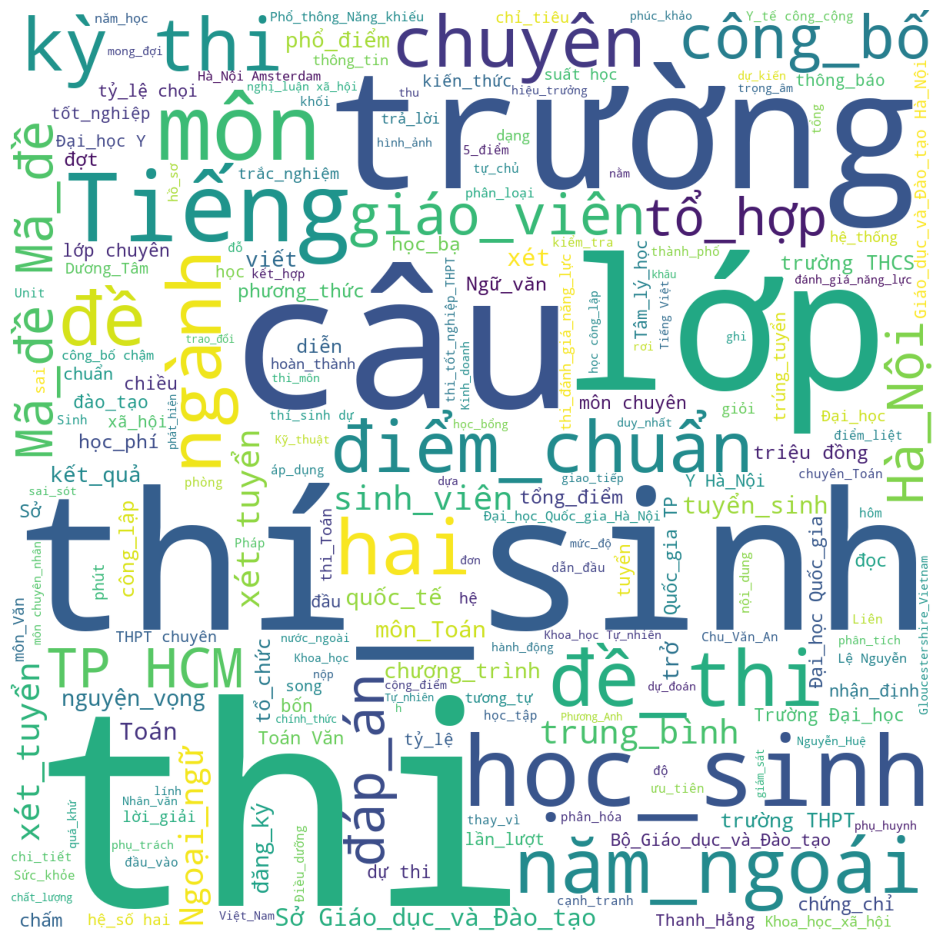

In [55]:
create_word_cloud(corpus, stopwords)

In [ ]:
# IUCFS

patterns = [
    r"#iu_\w+",
    r"\d{2}/\d{2}/\d{4} \d{2}:\d{2}:\d{2}",
    r"[-~_][\w\s]*?[-~_]",
    r"[^\w\s]",
    r"sua dua",
]